In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors
from datetime import timedelta
import git
import yaml

In [2]:
# Custom code to load .list files
import stuff

# Variable PSF, bands R and G

In [3]:
repo = git.Repo('/home/aalvarez/Work/Projects/sextractorxx/')
print(repo.head.ref)

group_pixel_boundaries


### Configuration

In [4]:
print(open('/home/aalvarez/Work/Data/sim09/test_multiframe.config').read())

measurement-config-file=/home/aalvarez/Work/Data/sim09/config.yaml
output-properties=PixelCentroid,SourceIDs,SourceFlags,MultiframeModelFitting
detection-image=/home/aalvarez/Work/Data/sim09/sim09.fits
weight-image=/home/aalvarez/Work/Data/sim09/sim09.weight.fits
weight-type=weight
detection-image-saturation=59000
detection-image-gain=1
detect-minarea=10
partition-min-area=10
threads-nb=4
cellsize-value=32
partition-multithreshold=true
grouping-algorithm=SPLIT
checkimage-residual=/home/aalvarez/Work/Data/sim09/mci_residual.fits
checkimage-modelfitting=/home/aalvarez/Work/Data/sim09/mci_modelfitting.fits
checkimage-background=/home/aalvarez/Work/Data/sim09/mci_background.fits
checkimage-variance=/home/aalvarez/Work/Data/sim09/mci_variance.fits
checkimage-segmentation=/home/aalvarez/Work/Data/sim09/mci_segmentation.fits
checkimage-partition=/home/aalvarez/Work/Data/sim09/mci_partition.fits
checkimage-filtered=/home/aalvarez/Work/Data/sim09/mci_filtered.fits

output-file=/home/aalvarez/Wo

In [5]:
multiframe_config = yaml.load(open('/home/aalvarez/Work/Data/sim09/config.yaml'))
print(yaml.dump(multiframe_config))

- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim09/sim09_g_*.fits, psf-path: /home/aalvarez/Work/Data/sim09/sim09_g_*.psf}
    name: g
- measurements-group:
    image-files:
    - {path: /home/aalvarez/Work/Data/sim09/sim09_r_*.fits, psf-path: /home/aalvarez/Work/Data/sim09/sim09_r_*.psf}
    name: r



## Load simulation data

In [6]:
r_stars, r_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_r.list')
g_stars, g_galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_g.list')

### Display coadded image

In [7]:
coadd_img = fits.open('/home/aalvarez/Work/Data/sim09/sim09.fits')[0]

Text(0.5,1,'Coadded image')

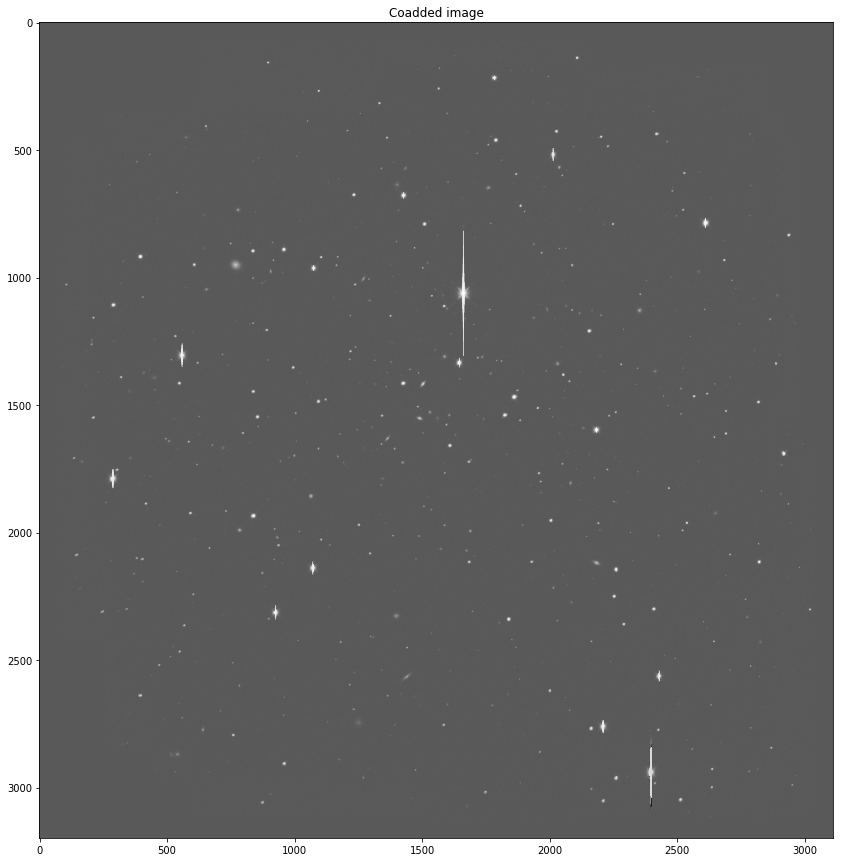

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(coadd_img.data, norm=colors.SymLogNorm(50), cmap=plt.get_cmap('Greys_r'))
plt.title('Coadded image')

### Build a KDTree with the source coordinates

In [9]:
# We imagine the coordinates are the same for all simulations!
assert(np.all(r_stars.ra == g_stars.ra) and np.all(r_stars.dec == g_stars.dec))
assert(np.all(r_galaxies.ra == g_galaxies.ra) and np.all(r_galaxies.dec == g_galaxies.dec))

stars_coords = np.stack([r_stars.ra, r_stars.dec]).T
galaxies_coords = np.stack([r_galaxies.ra, r_galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)
r_mags = np.append(r_stars.mag, r_galaxies.mag)
g_mags = np.append(g_stars.mag, g_galaxies.mag)

n_stars = len(r_stars)
n_galaxies = len(r_galaxies)

### Load the output catalog

In [10]:
output_catalog = Table.read('/home/aalvarez/Work/Data/sim09/merged.fits')
# Filter out those that were cut out of the model fitting
output_catalog = output_catalog[((np.isnan(output_catalog['mmf_x']) | np.isnan(output_catalog['mmf_y']))==False)]

Compute magnitudes

In [11]:
# This comes from sim09_*_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [12]:
output_catalog['g_mag'] = mag_zeropoint - 2.5 * np.log10(output_catalog['mmf_fluxes'][:,0] / exp_time)
output_catalog['r_mag'] = mag_zeropoint - 2.5 * np.log10(output_catalog['mmf_fluxes'][:,1] / exp_time)

Note that some entries witll have NaN, since they may not have been on the images used to run SExtractor.

## Compare results

In [13]:
def get_closest(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['mmf_alpha'], e['mmf_delta']], 1)
        distances.append(d)
        index_c.append(i)
        index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'source': np.array(index_s),
    }

In [14]:
closest = get_closest(output_catalog)

In [15]:
print("Number of sources found:", len(closest['dist']))

Number of sources found: 1260


In [16]:
def plot_stats(ax, data):
    ax.text(
        0.7, 0.7,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
        ),
        transform=ax.transAxes
    )

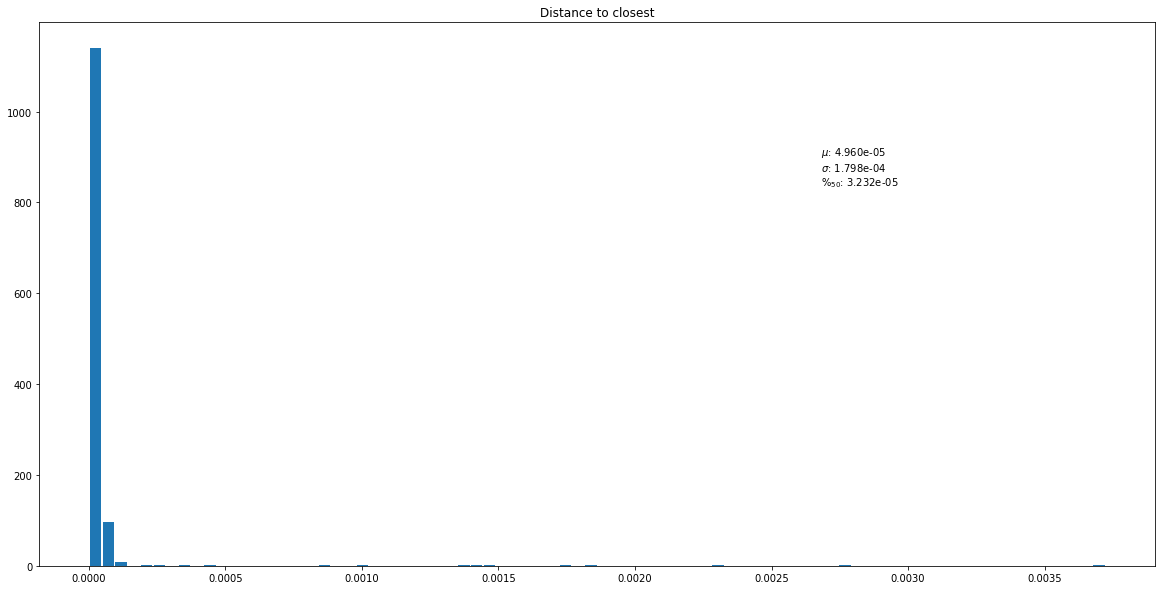

In [17]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(closest['dist'], 80, rwidth=0.9)
plot_stats(ax1, closest['dist'])
_ = ax1.set_title('Distance to closest')

### Magnitudes

In [18]:
r_mag_diff = output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']]
g_mag_diff = output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']]

# Filter NaN and outliers
r_not_nan = (np.isnan(r_mag_diff) == False)
g_not_nan = (np.isnan(g_mag_diff) == False)
r_outlier_filter = r_not_nan & (r_mag_diff >= np.percentile(r_mag_diff[r_not_nan], 5)) & (r_mag_diff <= np.percentile(r_mag_diff[r_not_nan], 95))
g_outlier_filter = g_not_nan & (g_mag_diff >= np.percentile(g_mag_diff[g_not_nan], 5)) & (g_mag_diff <= np.percentile(g_mag_diff[g_not_nan], 95))

/home/aalvarez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys
/home/aalvarez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/home/aalvarez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
/home/aalvarez/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


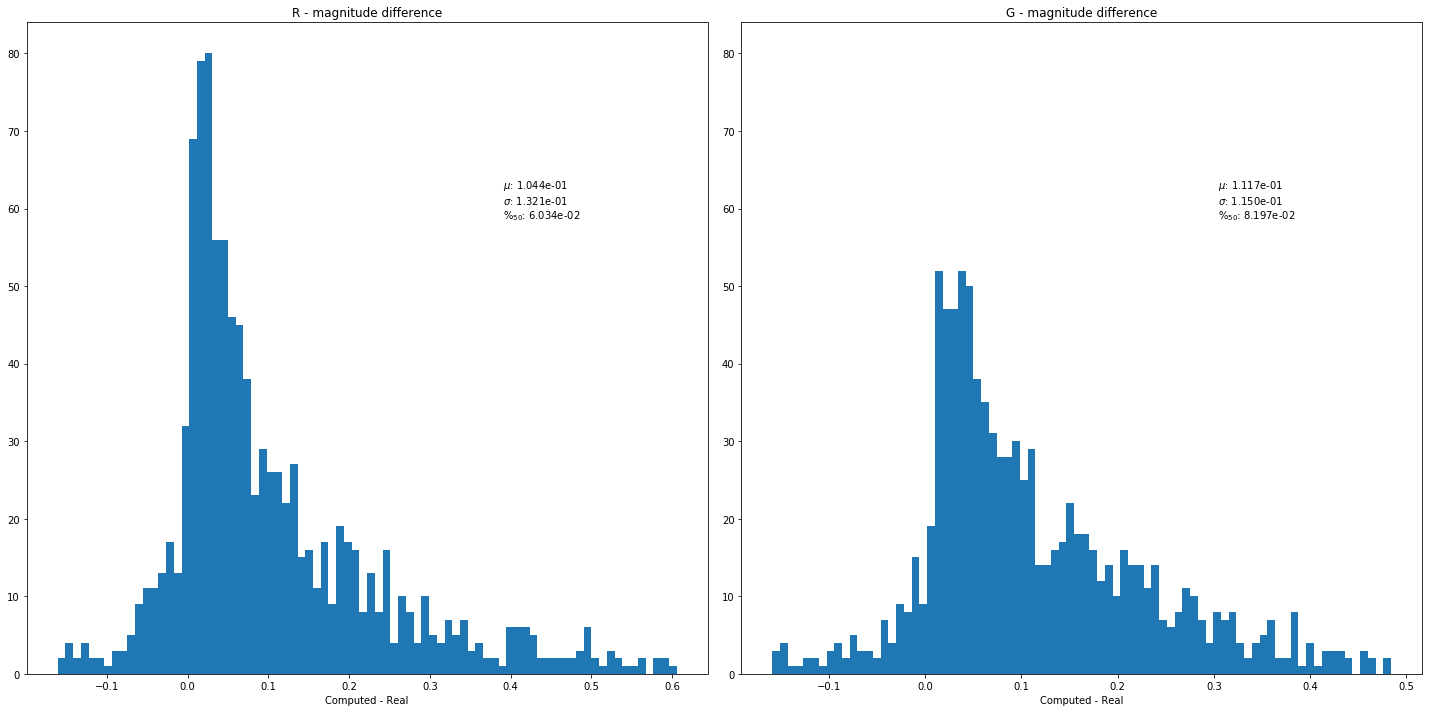

In [19]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(r_mag_diff[r_outlier_filter], 80)
ax1.set_xlabel('Computed - Real')
plot_stats(ax1, r_mag_diff[r_outlier_filter])
ax1.set_title('R - magnitude difference')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
ax2.hist(g_mag_diff[g_outlier_filter], 80)
ax2.set_xlabel('Computed - Real')
plot_stats(ax2, g_mag_diff[g_outlier_filter])
_ = ax2.set_title('G - magnitude difference')

plt.tight_layout()

In [20]:
g_saturated = (np.array([output_catalog[closest['catalog']][f'source_flags_g_{i}'] for i in range(1,11)]) & 4).sum(axis=0) > 0
r_saturated = (np.array([output_catalog[closest['catalog']][f'source_flags_r_{i}'] for i in range(1,11)]) & 4).sum(axis=0) > 0
print(g_saturated.sum())
print(r_saturated.sum())

8
18


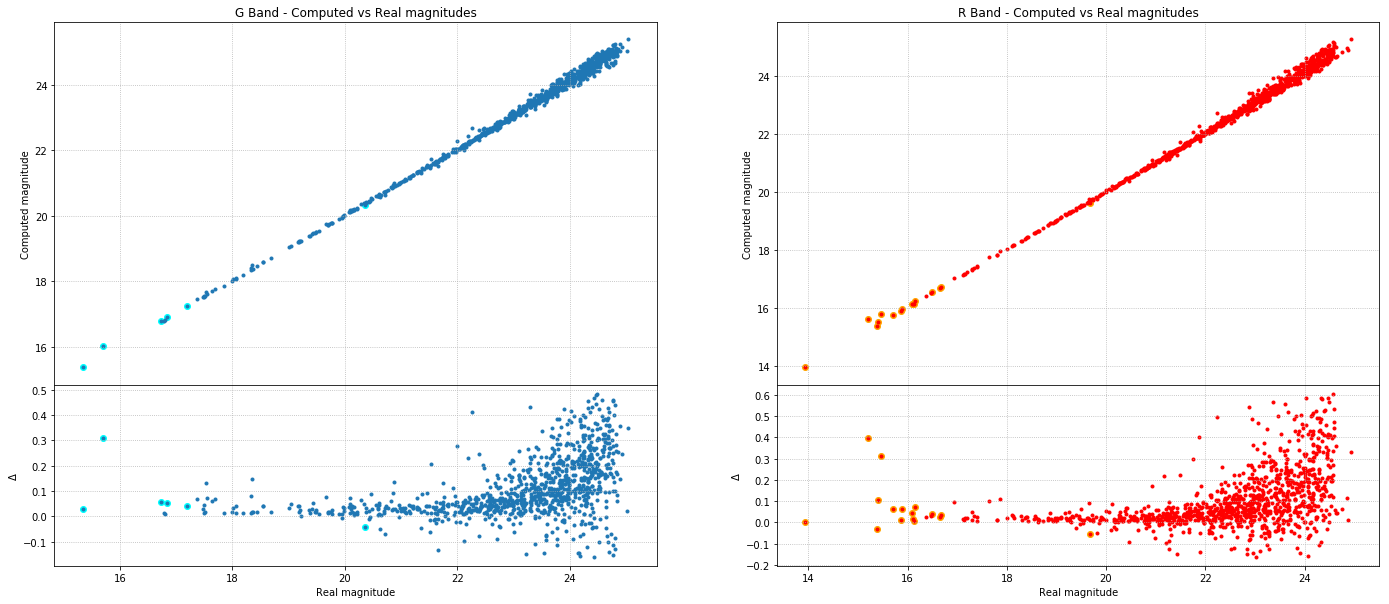

In [21]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(left=0.07, right=0.99, hspace=0.0, wspace=0.2)

ax1 = plt.subplot2grid((3, 2), (0, 0), 2)
ax1.scatter(
    g_mags[closest['source']][g_outlier_filter & g_saturated],
    output_catalog[closest['catalog']]['g_mag'][g_outlier_filter & g_saturated],
    marker='o', color='cyan'
)
ax1.scatter(
    g_mags[closest['source']][g_outlier_filter],
    output_catalog[closest['catalog']]['g_mag'][g_outlier_filter],
    marker='.'
)
ax1.set_ylabel('Computed magnitude')
ax1.set_xlabel('Real magnitude')
ax1.grid(True, linestyle=':')
ax1.set_title('G Band - Computed vs Real magnitudes')

ax2 = plt.subplot2grid((3, 2), (2, 0), 1)
ax2.scatter(
    g_mags[closest['source']][g_outlier_filter & g_saturated],
    (output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']])[g_outlier_filter & g_saturated],
    marker='o', color='cyan'
)
ax2.scatter(
    g_mags[closest['source']][g_outlier_filter],
    (output_catalog[closest['catalog']]['g_mag'] - g_mags[closest['source']])[g_outlier_filter],
    marker='.'
)
ax2.set_ylabel('$\Delta$')
ax2.set_xlabel('Real magnitude')
ax2.grid(True, linestyle=':')

ax3 = plt.subplot2grid((3, 2), (0, 1), 2)
ax3.scatter(
    r_mags[closest['source']][r_outlier_filter & r_saturated],
    output_catalog[closest['catalog']]['r_mag'][r_outlier_filter & r_saturated],
    marker='o', c='orange'
)
ax3.scatter(
    r_mags[closest['source']][r_outlier_filter],
    output_catalog[closest['catalog']]['r_mag'][r_outlier_filter],
    marker='.', c='red'
)
ax3.set_ylabel('Computed magnitude')
ax3.set_xlabel('Real magnitude')
ax3.grid(True, linestyle=':')
ax3.set_title('R Band - Computed vs Real magnitudes')

ax4 = plt.subplot2grid((3, 2), (2, 1), 1)
ax4.scatter(
    r_mags[closest['source']][r_outlier_filter & r_saturated],
    (output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']])[r_outlier_filter & r_saturated],
    marker='o', c='orange'
)
ax4.scatter(
    r_mags[closest['source']][r_outlier_filter],
    (output_catalog[closest['catalog']]['r_mag'] - r_mags[closest['source']])[r_outlier_filter],
    marker='.', c='red'
)
ax4.set_ylabel('$\Delta$')
ax4.set_xlabel('Real magnitude')
ax4.grid(True, linestyle=':')

_ = 0

Which ones are bright sources in the 'R' band and are not saturated?

In [22]:
odd_r_source_filter = (r_mags[closest['source']] < 16) & (r_saturated == False) & r_outlier_filter
odd_g_source_filter = (g_mags[closest['source']] < 16) & (g_saturated == False) & g_outlier_filter

In [23]:
odd_r_source = closest['source'][odd_r_source_filter]
odd_g_source = closest['source'][odd_g_source_filter]

In [24]:
print(r_mags[closest['source']][odd_r_source_filter])
print(g_mags[closest['source']][odd_g_source_filter])

[]
[]
